<a href="https://colab.research.google.com/github/Hee0305/DL/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# import cv2
print(tf.__version__)

2.7.0


In [2]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


**Load Data**

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10

x_train,_ = train_test_split(x_train,test_size=0.9,random_state=304,shuffle=True)
y_train,_ = train_test_split(y_train,test_size=0.9,random_state=304,shuffle=True)

print(x_train.shape)
print(y_train.shape)


y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


170508288/170498071 [==============================] - 3s 0us/step
(5000, 32, 32, 3)
(5000, 1)


**Data augmentation**

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255.,
                             #validation_split=0.9, # 50,000 -> 5,000                           
                             rotation_range=15, # 이미지 회전값
                             shear_range=0.5, # 이미지 기울기
                             width_shift_range=0.1, # 좌우이동
                             height_shift_range=0.1, # 상하이동
                             horizontal_flip=True
                             # brightness_range=[0.8,1.2], # 밝기
                             #zoom_range=[0.7,1.0] # 확대 
                             )
datagen.fit(x_train)

datagen2 = ImageDataGenerator(rescale=1./255.,)

valid_generator = datagen2.flow(x_test,
                               y_test,
                               batch_size=batch_size,
                               seed=42
                               )


generate_img_num = 2
generated_data = []
generated_data_label = []
for index in range(len(x_train)):
  count = 0
  x = x_train[index].reshape((1,) + x_train[index].shape)
  for batch in datagen.flow(x, batch_size=1):
    count += 1
    generated_data.append(batch)
    generated_data_label.append(y_train[index])
    if count == generate_img_num: 
        break

x_train = np.squeeze(np.array(generated_data))

y_train = np.array(generated_data_label)



In [6]:
# print(len(train_generator))
print(len(valid_generator))

313


In [7]:
# print(train_generator.n)
print(valid_generator.n)

10000


**Model ( MobileNetV2 )**

In [8]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
len(TL_base.layers)

154

In [10]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

**Sequential model**

In [12]:
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [13]:
TL_base = models.Model(TL_base.input, TL_base.layers[-4].output)
TL_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
ko = tf.keras.optimizers.SGD(lr=0.0001,momentum=0.9) # Adam -> SGD 변경

input_tensor = layers.Input(shape=(32,32,3))
#이미지 리사이즈
up1 = tf.image.resize(input_tensor,(224,224))

#skip connection 
ori_img = tf.image.resize(input_tensor,(7,7))

#pretrain모델 불러오기
base_mob = TL_base(up1)


def conv_model2(base_mob,ori_img):
  act0 = tf.nn.relu(base_mob)
  conv1 = layers.Conv2D(10, 7, padding='same')(act0)
  BN1 = layers.BatchNormalization()(conv1)
  act1 = tf.nn.relu(BN1)

  concat = layers.concatenate([ori_img, act1], axis=3)


  average_pool = layers.GlobalAveragePooling2D()(concat)

  TL_1 = layers.Flatten()(average_pool)

  TL_2 = layers.Dense(64,activation='relu')(TL_1)
  # drop1 = layers.Dropout(0.2)(TL_2)
  TL_3 = layers.Dense(32,activation='relu')(TL_2)
  output_tensor = layers.Dense(10,activation='softmax')(TL_3)

  return output_tensor



def dense_model(base_mob):

  TL_0 = layers.GlobalAveragePooling2D()(base_mob)
  TL_1 = layers.Flatten()(TL_0)
  
  TL_2 = layers.Dense(4096,activation='relu')(TL_1)
  drop1 = layers.Dropout(0.3)(TL_2)
  TL_3 = layers.Dense(2048,activation='relu')(drop1)
  drop2 = layers.Dropout(0.3)(TL_3)
  TL_4 = layers.Dense(1024,activation='relu')(drop2)
  drop3 = layers.Dropout(0.2)(TL_4)  
  TL_5 = layers.Dense(512,activation='relu')(drop3)
  drop4 = layers.Dropout(0.2)(TL_5)  
  TL_6 = layers.Dense(256,activation='relu')(drop4)
  drop5 = layers.Dropout(0.2)(TL_6)
  TL_7 = layers.Dense(128,activation='relu')(drop5)
  output_tensor = layers.Dense(10,activation='softmax')(TL_7)

  return output_tensor



#output_tensor = average_pool_model(base_mob)
#output_tensor = conv_model(base_mob,ori_img)
#output_tensor = conv_model3(base_mob,ori_img)
#output_tensor = conv_model5(base_mob,ori_img)

#best
output_tensor = conv_model2(base_mob,ori_img)
#output_tensor = dense_model(base_mob)
model = models.Model(input_tensor, output_tensor)







/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 320)    1843264     ['tf.image.resize[0][0]']        
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 7, 7, 320)    0           ['model[0][0]']                  
                                                                                            

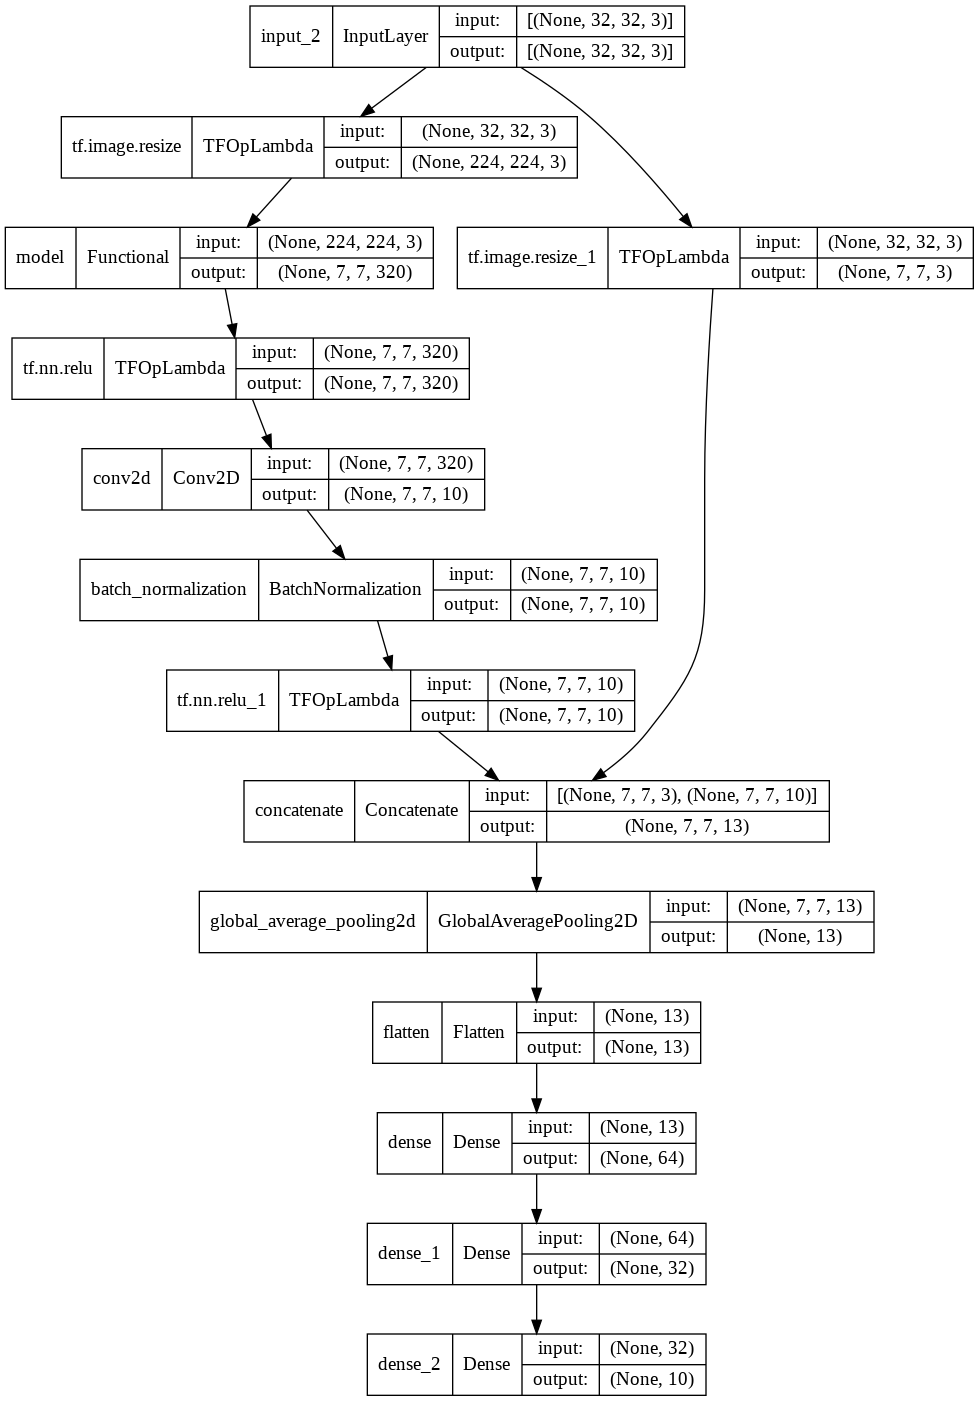

In [16]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [17]:
from tensorflow.keras import layers, models, callbacks

In [18]:
mc_callback = callbacks.ModelCheckpoint(filepath="./best_model.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=15)
model.compile(optimizer = ko , loss='categorical_crossentropy', metrics = ['accuracy'])

In [19]:
STEP_SIZE_TRAIN=x_train.shape[0]//batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(x=x_train,y=y_train,
                    batch_size = batch_size,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,callbacks=[mc_callback,es_callback])


Epoch 1/1000
313/313 [==============================] - ETA: 0s - loss: 2.2263 - accuracy: 0.1552

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


313/313 [==============================] - 82s 220ms/step - loss: 2.2263 - accuracy: 0.1552 - val_loss: 2.1541 - val_accuracy: 0.1562
Epoch 2/1000
313/313 [==============================] - 67s 215ms/step - loss: 2.1477 - accuracy: 0.1998 - val_loss: 2.0770 - val_accuracy: 0.1993
Epoch 3/1000
313/313 [==============================] - 50s 159ms/step - loss: 2.0931 - accuracy: 0.2555 - val_loss: 2.0178 - val_accuracy: 0.2670
Epoch 4/1000
313/313 [==============================] - 67s 214ms/step - loss: 2.0445 - accuracy: 0.3114 - val_loss: 1.9678 - val_accuracy: 0.3263
Epoch 5/1000
313/313 [==============================] - 50s 159ms/step - loss: 2.0037 - accuracy: 0.3500 - val_loss: 1.9209 - val_accuracy: 0.3751
Epoch 6/1000
313/313 [==============================] - 50s 159ms/step - loss: 1.9592 - accuracy: 0.3919 - val_loss: 1.8727 - val_accuracy: 0.4082
Epoch 7/1000
313/313 [==============================] - 50s 160ms/step - loss: 1.9160 - accuracy: 0.4220 - val_loss: 1.8238 - val_a

In [20]:
#best model load
myModel = load_model("./best_model.hdf5")
myModel.summary()
#predict
y_pred = myModel.predict(x_test/255.)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 320)    1843264     ['tf.image.resize[0][0]']        
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 7, 7, 320)    0           ['model[0][0]']                  
                                                                                            

**Fine tuning**

In [21]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  151


In [23]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [24]:
# Compile model
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 320)    1843264     ['tf.image.resize[0][0]']        
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 7, 7, 320)    0           ['model[0][0]']                  
                                                                                            

In [26]:
mc_callback = callbacks.ModelCheckpoint(filepath="./best_model.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=15)


**Train fine-tuned model**

In [27]:
history_dict = history.history
loss = history_dict['loss']

INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [28]:
%%time
history = model.fit(x=x_train,y=y_train,
                    batch_size = batch_size,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,callbacks=[mc_callback,es_callback])

Epoch 1/1000
313/313 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.7333

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


313/313 [==============================] - 80s 243ms/step - loss: 0.7738 - accuracy: 0.7333 - val_loss: 1.2543 - val_accuracy: 0.6059
Epoch 2/1000
313/313 [==============================] - 57s 182ms/step - loss: 0.2994 - accuracy: 0.8998 - val_loss: 2.2133 - val_accuracy: 0.5003
Epoch 3/1000
313/313 [==============================] - 57s 183ms/step - loss: 0.1372 - accuracy: 0.9585 - val_loss: 1.0431 - val_accuracy: 0.7188
Epoch 4/1000
313/313 [==============================] - 57s 182ms/step - loss: 0.0766 - accuracy: 0.9792 - val_loss: 1.3291 - val_accuracy: 0.6884
Epoch 5/1000
313/313 [==============================] - 57s 184ms/step - loss: 0.0512 - accuracy: 0.9870 - val_loss: 1.1225 - val_accuracy: 0.7361
Epoch 6/1000
313/313 [==============================] - 57s 184ms/step - loss: 0.0364 - accuracy: 0.9919 - val_loss: 0.8300 - val_accuracy: 0.7956
Epoch 7/1000
313/313 [==============================] - 57s 183ms/step - loss: 0.0306 - accuracy: 0.9934 - val_loss: 1.0080 - val_a

In [30]:
#best model load
mymodel = load_model("./best_model.hdf5")
myModel.summary()
#predict
y_pred = myModel.predict(x_test/255.)

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y_pred,axis = 1))
# acc = np.sum(np.diag(CM))/np.sum(CM)
# print(acc)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 7, 7, 320)    1843264     ['tf.image.resize[0][0]']        
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 7, 7, 320)    0           ['model[0][0]']                  
                                                                                            

**Val_acc**

In [31]:
model.evaluate(valid_generator, batch_size=32)

tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

313/313 [==============================] - 25s 81ms/step - loss: 0.7969 - accuracy: 0.8221
Number of layers in the base model:  151


**confusion Maxtrix**

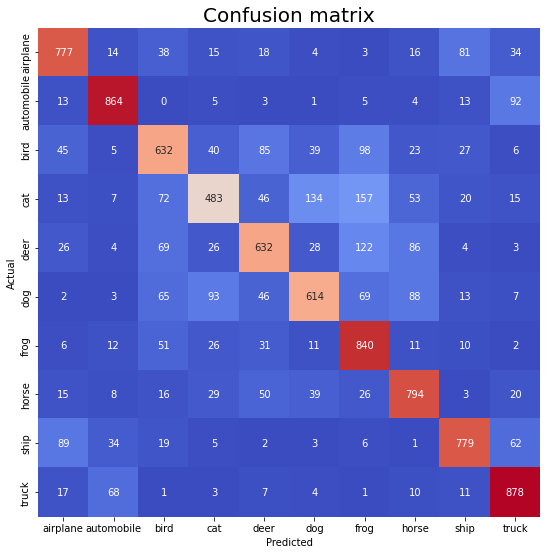

In [32]:
import seaborn as sns
plt.figure(figsize=(9,9))
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(CM, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()